Processing: 4.png


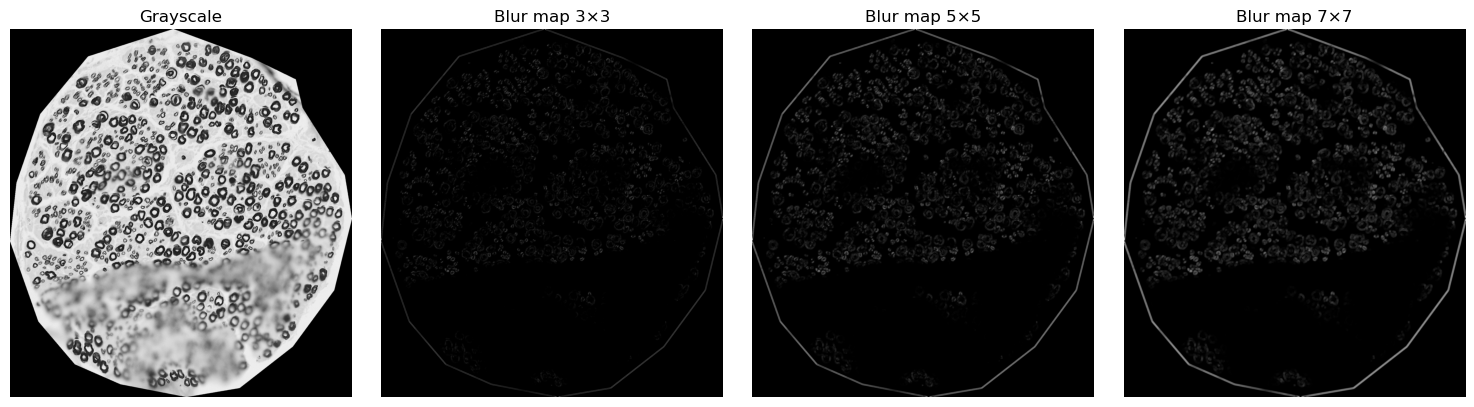

In [2]:
import cv2
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt

# ==============================
# CONFIG
# ==============================
# INPUT_DIR = r"C:\Users\3kp05\Desktop\Neural_Biopsy-main\new semester\all fascicles\set2_Image_01_20x_bf_05_all"
# OUTPUT_DIR = r"C:\Users\3kp05\Downloads\blur_maps_set2_Image_01_20x_bf_05_all"
INPUT_IMAGE = r"C:\Users\3kp05\Desktop\Neural_Biopsy-main\new semester\all fascicles\set2_Image_01_20x_bf_05_all\4.png"
OUTPUT_DIR = r"C:\Users\3kp05\Downloads\threshold_blur_maps_single_image"
WINDOW_SIZES = [3, 5, 7]

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ==============================
# Function: local Laplacian variance
# ==============================
def local_laplacian_variance(lap_img, k):
    mean = cv2.blur(lap_img, (k, k))
    mean_sq = cv2.blur(lap_img ** 2, (k, k))
    var = mean_sq - mean ** 2
    var = cv2.normalize(var, None, 0, 255, cv2.NORM_MINMAX)
    return var.astype(np.uint8)

# ==============================
# Process all PNG images
# ==============================
# png_files = glob(os.path.join(INPUT_DIR, "*.png"))

# if len(png_files) == 0:
#     raise RuntimeError("No PNG images found in input directory!")

# for img_path in png_files:
img_path = INPUT_IMAGE
filename = os.path.splitext(os.path.basename(img_path))[0]
    
print(f"Processing: {filename}.png")

    # Read image
img = cv2.imread(img_path)
if img is None:
    # print(f"⚠️ Could not read {img_path}, skipping.")
    # continue
    raise RuntimeError(f"❌ Could not read image: {img_path}")

    # Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Output subfolder per image
img_out_dir = os.path.join(OUTPUT_DIR, filename)
os.makedirs(img_out_dir, exist_ok=True)

    # --------------------------
    # Save Gaussian low-pass outputs
    # --------------------------
    # for k in WINDOW_SIZES:
    #     gaussian = cv2.GaussianBlur(gray, (k, k), 0)
    #     gauss_path = os.path.join(img_out_dir, f"gaussian_{k}x{k}.png")
    #     cv2.imwrite(gauss_path, gaussian)

    # --------------------------
    # Denoising for Laplacian
    # --------------------------
gray_denoised = cv2.GaussianBlur(gray, (3, 3), 0)
# standard deviation of the Gaussian along X
# If sigmaX = 0, it is automatically computed from kernel size
# gray_denoised=gray
    # Laplacian
lap = cv2.Laplacian(gray_denoised, cv2.CV_64F)
lap = np.abs(lap)

    # --------------------------
    # Blur maps (multi-scale)
    # --------------------------
# for k in WINDOW_SIZES:
#     blur_map = local_laplacian_variance(lap, k)
#     out_path = os.path.join(img_out_dir, f"blur_map_{k}x{k}.png")
#     cv2.imwrite(out_path, blur_map)

# # print("✅ Done processing all PNG images.")
# print("✅ Done processing one PNG images.")

# ==============================
# Display results
# ==============================
plt.figure(figsize=(15, 4))

# Original
plt.subplot(1, len(WINDOW_SIZES) + 1, 1)
plt.imshow(gray, cmap='gray')
plt.title("Grayscale")
plt.axis("off")

# Blur maps
for i, k in enumerate(WINDOW_SIZES, start=2):
    blur_map = local_laplacian_variance(lap, k)
    plt.subplot(1, len(WINDOW_SIZES) + 1, i)
    plt.imshow(blur_map, cmap='gray')
    plt.title(f"Blur map {k}×{k}")
    plt.axis("off")

plt.tight_layout()
plt.show()

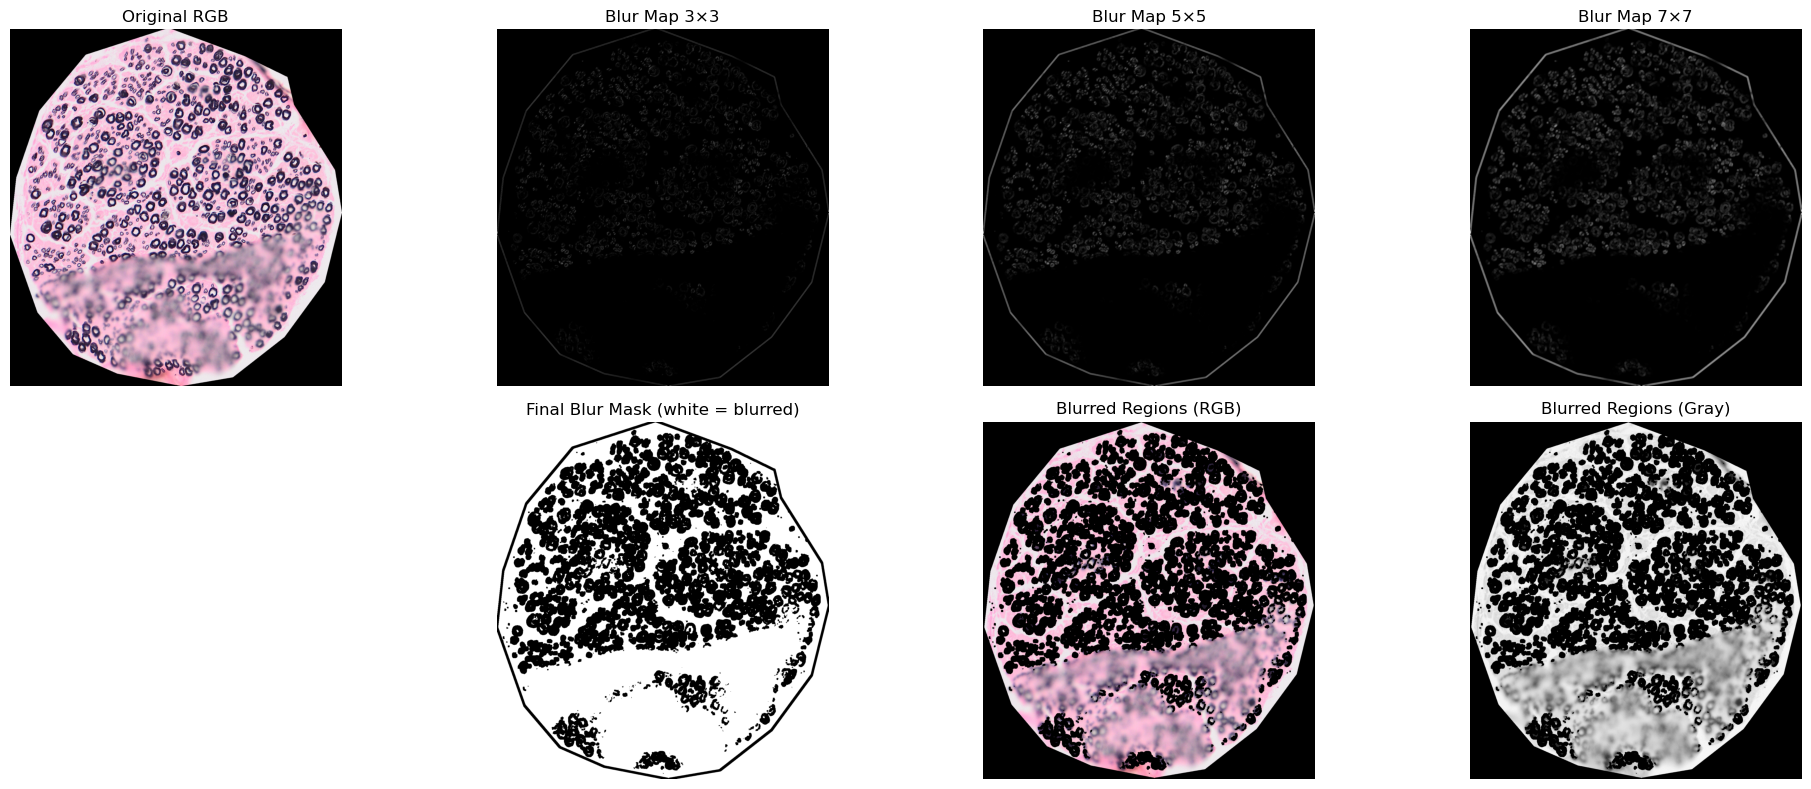

In [3]:
# ==============================
# Multi-scale blur mask → RGB result
# ==============================

PERCENTILE_THRESHOLD = 30   # lower = stricter blur

def get_blur_mask(blur_map, percentile=30):
    thresh = np.percentile(blur_map, percentile)
    mask = np.zeros_like(blur_map, dtype=np.uint8)
    mask[blur_map <= thresh] = 255   # blurred = white
    return mask


# ---- compute blur maps and masks for all scales ----
blur_maps = []
blur_masks = []

for k in WINDOW_SIZES:
    bm = local_laplacian_variance(lap, k)
    blur_maps.append(bm)
    blur_masks.append(get_blur_mask(bm, PERCENTILE_THRESHOLD))


# # ---- combine masks (OR logic) ----
# final_blur_mask = np.zeros_like(blur_masks[0], dtype=np.uint8)
# for m in blur_masks:
#     final_blur_mask = cv2.bitwise_or(final_blur_mask, m)

final_blur_mask = blur_masks[-1]   # 7×7



# ---- apply mask to grayscale ----
blurred_regions_gray = cv2.bitwise_and(gray, gray, mask=final_blur_mask)


# ---- apply mask to RGB ----
final_blur_mask_rgb = cv2.cvtColor(final_blur_mask, cv2.COLOR_GRAY2BGR)
blurred_regions_rgb = cv2.bitwise_and(img, final_blur_mask_rgb)
blurred_regions_rgb = cv2.cvtColor(blurred_regions_rgb, cv2.COLOR_BGR2RGB)

original_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


# ==============================
# Display
# ==============================
plt.figure(figsize=(20,8))

plt.subplot(2,4,1)
plt.imshow(original_rgb)
plt.title("Original RGB")
plt.axis("off")

for i, k in enumerate(WINDOW_SIZES):
    plt.subplot(2,4,2+i)
    plt.imshow(blur_maps[i], cmap='gray')
    plt.title(f"Blur Map {k}×{k}")
    plt.axis("off")

plt.subplot(2,4,6)
plt.imshow(final_blur_mask, cmap='gray')
plt.title("Final Blur Mask (white = blurred)")
plt.axis("off")

plt.subplot(2,4,7)
plt.imshow(blurred_regions_rgb)
plt.title("Blurred Regions (RGB)")
plt.axis("off")

plt.subplot(2,4,8)
plt.imshow(blurred_regions_gray, cmap='gray')
plt.title("Blurred Regions (Gray)")
plt.axis("off")

plt.tight_layout()
plt.show()


In [4]:
# os.makedirs(OUTPUT_DIR, exist_ok=True)

# # 1️⃣ Save Final Blur Mask (grayscale)
# mask_path = os.path.join(OUTPUT_DIR, "final_blur_mask.png")
# cv2.imwrite(mask_path, final_blur_mask)

# # 2️⃣ Save Blurred Regions (Gray)
# blur_gray_path = os.path.join(OUTPUT_DIR, "blurred_regions_gray.png")
# cv2.imwrite(blur_gray_path, blurred_regions_gray)

# # 3️⃣ Save Blurred Regions (RGB)
# # IMPORTANT: convert RGB back to BGR before saving
# blur_rgb_bgr = cv2.cvtColor(blurred_regions_rgb, cv2.COLOR_RGB2BGR)
# blur_rgb_path = os.path.join(OUTPUT_DIR, "blurred_regions_rgb.png")
# cv2.imwrite(blur_rgb_path, blur_rgb_bgr)

# print("✅ Saved:")
# print(mask_path)
# print(blur_gray_path)
# print(blur_rgb_path)


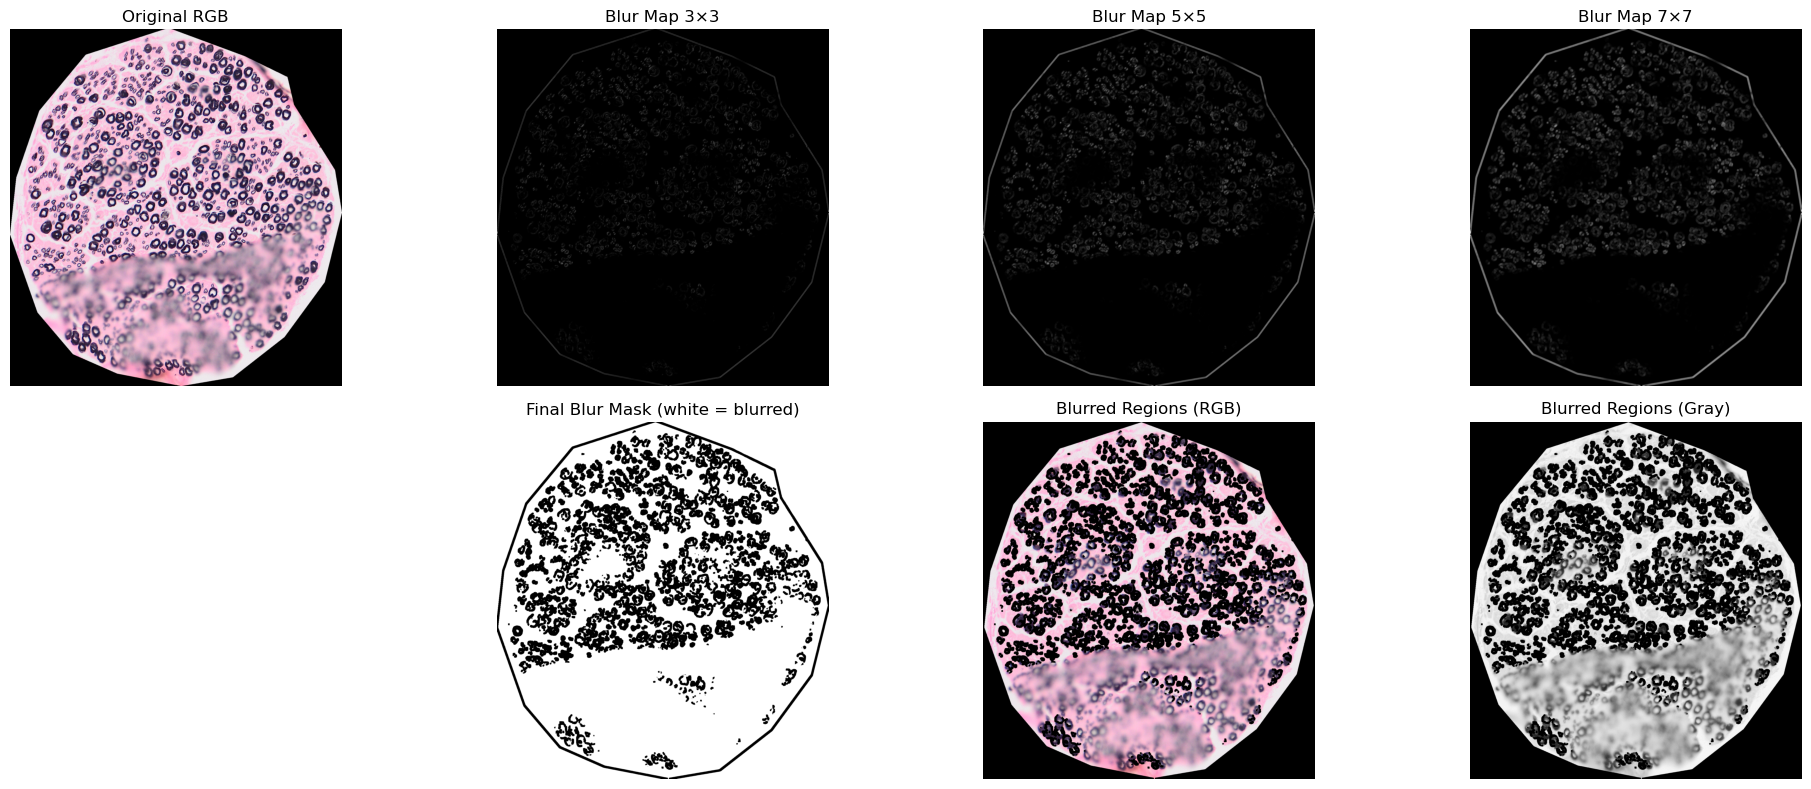

In [7]:
# ==============================
# Multi-scale blur mask → RGB result
# ==============================

PERCENTILE_THRESHOLD = 75   # lower = stricter blur

def get_blur_mask(blur_map, percentile=30):
    thresh = np.percentile(blur_map, percentile)
    mask = np.zeros_like(blur_map, dtype=np.uint8)
    mask[blur_map <= thresh] = 255   # blurred = white
    return mask


# ---- compute blur maps and masks for all scales ----
blur_maps = []
blur_masks = []

for k in WINDOW_SIZES:
    bm = local_laplacian_variance(lap, k)
    blur_maps.append(bm)
    blur_masks.append(get_blur_mask(bm, PERCENTILE_THRESHOLD))


# # ---- combine masks (OR logic) ----
# final_blur_mask = np.zeros_like(blur_masks[0], dtype=np.uint8)
# for m in blur_masks:
#     final_blur_mask = cv2.bitwise_or(final_blur_mask, m)

final_blur_mask = blur_masks[-1]   # 7×7



# ---- apply mask to grayscale ----
blurred_regions_gray = cv2.bitwise_and(gray, gray, mask=final_blur_mask)


# ---- apply mask to RGB ----
final_blur_mask_rgb = cv2.cvtColor(final_blur_mask, cv2.COLOR_GRAY2BGR)
blurred_regions_rgb = cv2.bitwise_and(img, final_blur_mask_rgb)
blurred_regions_rgb = cv2.cvtColor(blurred_regions_rgb, cv2.COLOR_BGR2RGB)

original_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


# ==============================
# Display
# ==============================
plt.figure(figsize=(20,8))

plt.subplot(2,4,1)
plt.imshow(original_rgb)
plt.title("Original RGB")
plt.axis("off")

for i, k in enumerate(WINDOW_SIZES):
    plt.subplot(2,4,2+i)
    plt.imshow(blur_maps[i], cmap='gray')
    plt.title(f"Blur Map {k}×{k}")
    plt.axis("off")

plt.subplot(2,4,6)
plt.imshow(final_blur_mask, cmap='gray')
plt.title("Final Blur Mask (white = blurred)")
plt.axis("off")

plt.subplot(2,4,7)
plt.imshow(blurred_regions_rgb)
plt.title("Blurred Regions (RGB)")
plt.axis("off")

plt.subplot(2,4,8)
plt.imshow(blurred_regions_gray, cmap='gray')
plt.title("Blurred Regions (Gray)")
plt.axis("off")

plt.tight_layout()
plt.show()
